In [1]:
import os
from datetime import datetime
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sklearn
import pandas as pd
import json
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms

Defino una red neuronal con $28*28=784$ neuronas de entrada, una capa oculta de $n$ neuronas y una capa de salida de $28*28=784$ neuronas. Luego definimos el train loop y validation loop. Devolvemos el error promedio para poder graficarlo despues

In [2]:
class Autoencoder(nn.Module):
    def __init__(self, n, p=0.1):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, n)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)
        self.fc2 = nn.Linear(n, 28*28)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        
        return x
    
def train_loop(dataloader, model, loss_fn, optimizer, device="cpu"):
    model.train()
    
    num_batches = len(dataloader)
    sum_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_value = loss.item()
        sum_loss += loss_value
        
        if batch % 10 == 0:
            print(f"batch = {batch}, loss = {loss_value}")
            
    avg_loss = sum_loss / num_batches
    return avg_loss

def valid_loop(dataloader, model, loss_fn, device="cpu"):
    model.eval()
    
    num_batches = len(dataloader)
    sum_loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            loss_value = loss_fn(pred, y).item()
            sum_loss += loss_value
    
    avg_loss = sum_loss / num_batches
    print(f"avg_loss = {avg_loss}")
    return avg_loss

Usamos el dataset de entrenamiento de FashionMNIST de $60.000$ imagenes. Este lo subdividimos aleatoriamente en un dataset de entrenamiento de $50.000$ y un dataset de validacion de $10.000$.
Ademas definimos una clase `AutoencoderDataset` que es la responsable de mapear cada input (imagen) a un output que es la misma imagen

In [59]:
transform = transforms.Compose([transforms.ToTensor()])

mnist_train_set = datasets.FashionMNIST("MNIST_data/", download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST("MNIST_data/", download=True, train=False, transform=transform)
train_size = 50000
valid_size = 10000
train_set, valid_set = torch.utils.data.random_split(mnist_train_set, [train_size, valid_size])

class AutoencoderDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        image, label = self.dataset[i]
        input = image
        output = torch.flatten(image)
        return input, output
    
train_set = AutoencoderDataset(train_set)
valid_set = AutoencoderDataset(valid_set)
test_set = AutoencoderDataset(test_set)

Creamos un modelo con $n=64, 128, 256, 512$ neuronas para la capa oculta y miramos el output para una imagen del dataset de entrenamiento. Como no hemos entrenado el modelo, los weights y bias estan inicializados aleatoriamente por lo tanto la imagen de output es completamente aleatoria.

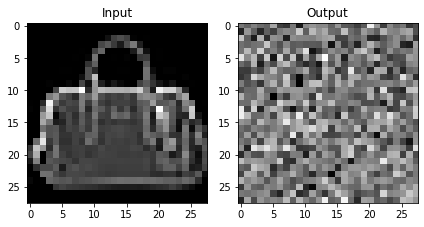

In [74]:
torch.set_num_threads(20)
model = Autoencoder(512)
image, _ = train_set[0]
pred = model(image)

plt.subplot(1,2,1)
plt.imshow(image.squeeze(), cmap="gray")
plt.title("Input")

plt.subplot(1,2,2)
plt.imshow(pred.detach().numpy().reshape(28, 28), cmap="gray")
plt.title("Output")

plt.tight_layout()

Entrenamos la red. Usamos MSE para el error, con un learning rate de $0.1$. Stochastic Gradient Descent para el optimizador. Usamos un tamaño de batch de $1000$

In [75]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 1000, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = 1000, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1000, shuffle = True)
loss_fn = nn.MSELoss()
learning_rate = 0.5
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs = 60
avg_loss_training_inc_list = np.zeros(num_epochs)
avg_loss_valid_list = np.zeros(num_epochs)
avg_loss_training_list = np.zeros(num_epochs)
    

for epoch in range(num_epochs):
    print(f"epoch {epoch+1}/{num_epochs}")
    avg_loss_training_inc_list[epoch] = train_loop(train_loader, model, loss_fn, optimizer, device)
    avg_loss_valid_list[epoch] = valid_loop(valid_loader, model, loss_fn, device)
    avg_loss_training_list[epoch] = valid_loop(train_loader, model, loss_fn, device)

epoch 1/60
batch = 0, loss = 0.2282402515411377
batch = 10, loss = 0.14232933521270752
batch = 20, loss = 0.08106091618537903
batch = 30, loss = 0.07203831523656845
batch = 40, loss = 0.0676935464143753
avg_loss = 0.06158180050551891
avg_loss = 0.061282320246100426
epoch 2/60
batch = 0, loss = 0.06697836518287659
batch = 10, loss = 0.06622830033302307
batch = 20, loss = 0.06283870339393616
batch = 30, loss = 0.06278981268405914
batch = 40, loss = 0.06060010939836502
avg_loss = 0.053935037553310396
avg_loss = 0.05371645964682102
epoch 3/60
batch = 0, loss = 0.05779997259378433
batch = 10, loss = 0.05775429308414459
batch = 20, loss = 0.05549696460366249
batch = 30, loss = 0.05337623506784439
batch = 40, loss = 0.05185269936919212
avg_loss = 0.04733687452971935
avg_loss = 0.04718913093209267
epoch 4/60
batch = 0, loss = 0.05296356976032257
batch = 10, loss = 0.05033695325255394
batch = 20, loss = 0.05039212852716446
batch = 30, loss = 0.04959774762392044
batch = 40, loss = 0.047359794378

batch = 20, loss = 0.02723567746579647
batch = 30, loss = 0.026257526129484177
batch = 40, loss = 0.026492195203900337
avg_loss = 0.02418372891843319
avg_loss = 0.023994189277291297
epoch 32/60
batch = 0, loss = 0.026273561641573906
batch = 10, loss = 0.026514258235692978
batch = 20, loss = 0.02709597535431385
batch = 30, loss = 0.02717144414782524
batch = 40, loss = 0.02713296376168728
avg_loss = 0.023985000140964986
avg_loss = 0.02379726115614176
epoch 33/60
batch = 0, loss = 0.026834804564714432
batch = 10, loss = 0.026614202186465263
batch = 20, loss = 0.02647370845079422
batch = 30, loss = 0.026890674605965614
batch = 40, loss = 0.026281848549842834
avg_loss = 0.023794265650212764
avg_loss = 0.023608303777873516
epoch 34/60
batch = 0, loss = 0.02594459056854248
batch = 10, loss = 0.0269529577344656
batch = 20, loss = 0.026763243600726128
batch = 30, loss = 0.02669248729944229
batch = 40, loss = 0.02584734931588173
avg_loss = 0.023609150759875776
avg_loss = 0.02342502437531948
epoc

Text(0.5, 0, 'epochs')

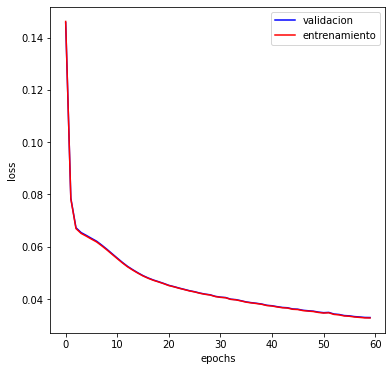

In [63]:
plt.figure(figsize=(6,6))
plt.plot(avg_loss_valid_list, c="blue")
plt.plot(avg_loss_training_list, c="red")
plt.legend(["validacion", "entrenamiento"])
#plt.plot(avg_loss_training_inc_list)
#plt.xlim([40, 80])
#plt.ylim([0.03, 0.04])
plt.ylabel("loss")
plt.xlabel("epochs")

In [64]:
avg_loss_valid_list

array([0.14572871, 0.07854167, 0.06723288, 0.06538885, 0.06431876,
       0.06318875, 0.0620922 , 0.06059266, 0.05900397, 0.05731107,
       0.05563798, 0.05398455, 0.05246815, 0.05119496, 0.05001022,
       0.04891932, 0.04802447, 0.04724696, 0.04661456, 0.04594242,
       0.04521131, 0.04471947, 0.04416357, 0.0436662 , 0.04315628,
       0.04276408, 0.04225993, 0.04186484, 0.04159315, 0.04100156,
       0.04069543, 0.04054217, 0.039919  , 0.03974111, 0.03932559,
       0.03886704, 0.03858114, 0.03834483, 0.03805769, 0.03758511,
       0.03740541, 0.03705215, 0.03675829, 0.03663806, 0.03617739,
       0.03607741, 0.03567608, 0.03549251, 0.03533536, 0.03497538,
       0.03475245, 0.03485634, 0.03424083, 0.03406367, 0.03365685,
       0.03353893, 0.0332614 , 0.03310882, 0.03292904, 0.03289994])

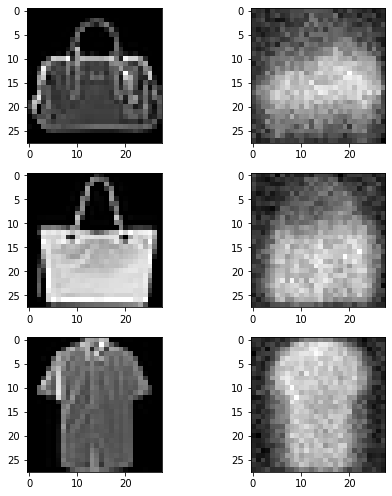

In [65]:
image, _ = train_set[0]
pred = model(image)

image2, _ = train_set[50]
pred2 = model(image2)

image3, _ = train_set[2]
pred3 = model(image3)

plt.figure(figsize=(7,7))
plt.subplot(3,2,1)
plt.imshow(image.squeeze(), cmap='gray')

plt.subplot(3,2,2)
plt.imshow(pred.detach().numpy().reshape(28, 28), cmap='gray')

plt.subplot(3,2,3)
plt.imshow(image2.squeeze(), cmap='gray')

plt.subplot(3,2,4)
plt.imshow(pred2.detach().numpy().reshape(28, 28), cmap='gray')

plt.subplot(3,2,5)
plt.imshow(image3.squeeze(), cmap='gray')

plt.subplot(3,2,6)
plt.imshow(pred3.detach().numpy().reshape(28, 28), cmap='gray')

plt.tight_layout()

Calculamos el error promedio sobre el conjunto de testeo

In [76]:
# n=64 => 0.03265
# n=128 => 0.02638
# n=256 => 0.02289
# n=512 => 0.02005
valid_loop(test_loader, model, loss_fn, device)

avg_loss = 0.020051280595362188


0.020051280595362188

Text(0, 0.5, 'avg loss')

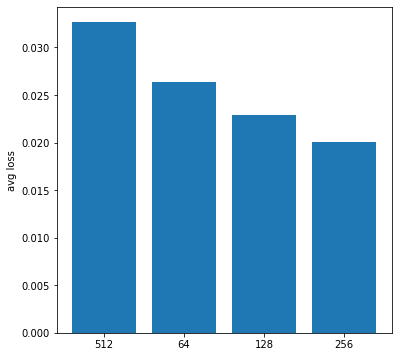

In [86]:
fig, ax = plt.subplots(figsize=(6,6))
ax.bar([1,2,3,4], [0.03265, 0.02638, 0.02289, 0.02005])
ax.set_xticks([1,2,3,4])
ax.set_xticklabels({"64","128","256","512"})
ax.set_ylabel("avg loss")